# 電腦看得懂的字典： WordNet
網頁版：http://wordnetweb.princeton.edu/perl/webwn

官網教學：http://www.nltk.org/howto/wordnet.html

## 名詞解釋
Synset: 同義詞集合

Hypernym：上位詞，如「水果」為「蘋果」的上位詞

Hyponym：下位詞，如「蘋果」為「水果」的下位詞

In [1]:
### WordNet
import nltk
nltk.download("wordnet") # 下載英文 WordNet
nltk.download("omw") # 下載多語 WordNet
from nltk.corpus import wordnet as wn

#同義詞、反義詞
good = wn.synset('good.a.01')
print("good 的定義： {}".format(good.definition()))
print("good 的例子： {}".format(good.examples()))
print("good 的同義詞： {}".format(good.lemmas()))
print("good 的反義詞： {}".format(good.lemmas()[0].antonyms()))

# 上位詞、下位詞
school = wn.synset('school.n.01')
print("school的上位詞: {}".format(school.hypernyms()))
print("school的下位詞: {}".format(school.hyponyms()))

# 更多關係
tree = wn.synset('tree.n.01') # 樹
print("很多樹我們稱作什麼？ {}".format(tree.member_holonyms()))
body = wn.synset('body.n.01') # 樹
print("身體有哪些部位？ {}".format(body.part_meronyms()))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
good 的定義： having desirable or positive qualities especially those suitable for a thing specified
good 的例子： ['good news from the hospital', 'a good report card', 'when she was good she was very very good', 'a good knife is one good for cutting', 'this stump will make a good picnic table', 'a good check', 'a good joke', 'a good exterior paint', 'a good secretary', 'a good dress for the office']
good 的同義詞： [Lemma('good.a.01.good')]
good 的反義詞： [Lemma('bad.a.01.bad')]
school的上位詞: [Synset('educational_institution.n.01')]
school的下位詞: [Synset('academy.n.03'), Synset('alma_mater.n.01'), Synset('conservatory.n.01'), Synset('correspondence_school.n.01'), Synset('crammer.n.03'), Synset('dance_school.n.01'), Synset('dancing_school.n.01'), Synset('day_school.n.02'), Synset('direct-grant_school.n.0

### 這份程式碼也可以用GPU進行加速。
### 於上面選單點選 "Runtime" -> "Change runtime type", 點選 "Hardware Accelerator" -> "GPU" ---- 別忘記點 "SAVE" 儲存噢！

----------------------------------------------------------------------

# BERT (Bidirectional Encoder Representations from Transformer)
*這份程式碼是基於新創公司HuggingFace在PyTorch Hub 的Colab Notebook所改編而成的，*
*原始的版本已經有克漏字與下句預測模型的demo，我們再加上多義詞的視覺化，特別在此感謝HuggingFace！*

**Bidirectional Encoder Representations from Transformers.**

_ | _
- | -
![alt](https://pytorch.org/assets/images/bert1.png) | ![alt](https://pytorch.org/assets/images/bert2.png)


### 使用到的模組

BERT 論文連結：[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

Transformer 論文連結：[Attention Is All You Need](https://arxiv.org/abs/1706.03762) 

 今天將會介紹的[Google訓練好的模型](https://github.com/google-research/bert) 包括：
- `bertTokenizer`: 將輸入的文字進行簡單的斷詞。
- `bertModel`: 訓練好的BERT模型。
- `bertForMaskedLM`: 訓練好的BERT克漏字模型。
- `bertForNextSentencePrediction`: 訓練好的BERT下句預測模型。

### 系統需求

BERT需要安裝一些額外的系統套件。點擊左方的play鍵來安裝吧！

In [2]:
%%bash
pip install tqdm boto3 requests regex


  Created wheel for regex: filename=regex-2019.6.8-cp36-cp36m-linux_x86_64.whl size=604159 sha256=50fd13602ebb6bbf5d1632c05daf4d227267590d9d94865125b7373dd5986828
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


### 將句子編碼成BERT看得懂的形式

In [3]:
import torch # 載入PyTorch
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'bertTokenizer', 'bert-base-chinese', do_basic_tokenize=True) # 將放在雲端上面的分字器(tokenizer)下載下來
# Tokenized input
def preprocess_two_sents(first_sent, second_sent, tokenizer=tokenizer):
    text = "".join(["[CLS]", first_sent, "[SEP]", second_sent, "[SEP]"]) # "[CLS] 醒醒吧，[SEP] 發大財。[SEP]" [SEP]: 告訴模型[SEP]前後屬於不同的句子
    tokenized_text = tokenizer.tokenize(text) # 用分字器進行簡單的分字： ['[CLS]', '醒', '醒', '吧', '，', '[SEP]', '發', '大', '財', '。', '[SEP]']
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text) # 將每個字編碼成BERT內部的編號(每個字都有一個專屬的編號) [101, 7008, 7008, 1416, 8024, 102, 4634, 1920, 6512, 511, 102] 
    tokens_tensor = torch.tensor([indexed_tokens]) # 將編號們轉成PyTorch看得懂的向量

    # 告訴BERT哪一個字屬於哪一句(0代表第一句，1代表第二句)
    sep_index = tokenizer.convert_tokens_to_ids(["[SEP]"])[0]
    first_sent_len = indexed_tokens.index(sep_index) + 1
    # [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
    segments_ids = [0] * first_sent_len + [1] * (len(indexed_tokens) - first_sent_len)
    segments_tensors = torch.tensor([segments_ids])

    return tokens_tensor, segments_tensors

first_sent = "醒醒吧，" # 第一句話
second_sent = "發大財。" # 第二句話
tokens_tensor, segments_tensors = preprocess_two_sents(first_sent, second_sent)

print("句子裡每個字的編號組成的向量： {}".format(tokens_tensor))
print("句子裡每個字屬於哪句話的向量： {}".format(segments_tensors))


Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 109540/109540 [00:00<00:00, 1013075.80B/s]

句子裡每個字的編號組成的向量： tensor([[ 101, 7008, 7008, 1416, 8024,  102, 4634, 1920, 6512,  511,  102]])
句子裡每個字屬於哪句話的向量： tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]])


In [4]:
### 計算考慮上下文的字向量

model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'bertModel', 'bert-base-chinese') # 將放在雲端上面的BERT模型下載下來
model.eval() # 將模型設爲預測模式

with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    encoded_layers, pooled_layers = model(tokens_tensor, segments_tensors) # 將句子編碼而成的向量傳入BERT模型，得到考慮上下文的字向量
print(encoded_layers.size()) # [句子數量，字數量，字向量長度]
print(pooled_layers.size()) # AVG(BERT(醒)，BERT(醒)，BERT(吧)，BERT(，)，BERT(發)，BERT(大)，BERT(財)，BERT(。))


Downloading: "https://github.com/huggingface/pytorch-pretrained-BERT/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 411577189/411577189 [00:08<00:00, 46888353.87B/s]


torch.Size([1, 11, 768])
torch.Size([1, 768])


In [5]:
### 下句預測模型

import torch.nn.functional as F

nextSent_model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'bertForNextSentencePrediction', 'bert-base-chinese') # 將放在雲端上面的BERT下句預測模型下載下來
nextSent_model.eval() # 將模型設爲預測模式

with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    next_sent_classif_logits = nextSent_model(tokens_tensor, segments_tensors)[0][0]
next_sent_classif_probs = F.softmax(next_sent_classif_logits)[0] # normalize成機率
is_next = next_sent_classif_logits[0] > 0.5 # 是下一句的機率大於0.5嗎？
print("「{}」 是 「{}」 的下一句嗎？ {}".format(second_sent, first_sent, bool(is_next)))

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master


「發大財。」 是 「醒醒吧，」 的下一句嗎？ True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [6]:
### BERT克漏字模型

def preprocess(sent, masked_indices=None): # 將句子編碼成編號向量，順便用[MASK]遮住我們想考BERT的字
    text = "[CLS]" + sent + "[SEP]"
    tokenized_text = tokenizer.tokenize(text)
    masked_tokens = []
    if masked_indices is not None:
        for masked_index in masked_indices:
            print("tokenized_text before masking: {}".format(tokenized_text))
            masked_tokens.append(tokenized_text[masked_index])
            tokenized_text[masked_index] = '[MASK]'
            print("tokenized_text after masking: {}".format(tokenized_text))

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [0] * len(tokenized_text)
    segments_tensors = torch.tensor([segments_ids])
    if masked_indices is not None:
      return masked_tokens, tokens_tensor, segments_tensors
    else:
      return tokens_tensor, segments_tensors

sent = "柯文哲創立台灣民眾黨。"
masked_indices = [9] # 要遮住第幾個字？
# masked_token: 被遮住的字，tokens_tensor: 句子裡每個字的編號組成的向量，segments_tensor: 句子裡每個字屬於哪句話的向量
masked_tokens, tokens_tensor, segments_tensors = preprocess(sent, masked_indices)

maskedLM_model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'bertForMaskedLM', 'bert-base-chinese') # 將放在雲端上面的BERT克漏字模型下載下來
maskedLM_model.eval() # 將模型設爲預測模式

with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    predictions = maskedLM_model(tokens_tensor, segments_tensors) # 將句子編碼而成的向量傳入BERT克漏字模型，得到每個字的

# Get the predicted token
print(predictions[0][0].size())
predicted_indices = torch.argmax(predictions[0][0], dim=-1)
print(predicted_indices)
predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_indices[masked_indices].tolist())
print("原字：{}; 模型預測：{}".format(masked_tokens, predicted_tokens))

tokenized_text before masking: ['[CLS]', '柯', '文', '哲', '創', '立', '台', '灣', '民', '眾', '黨', '。', '[SEP]']
tokenized_text after masking: ['[CLS]', '柯', '文', '哲', '創', '立', '台', '灣', '民', '[MASK]', '黨', '。', '[SEP]']


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master


torch.Size([13, 21128])
tensor([8024, 3392, 3152, 1528, 1201, 4989, 1378, 4124, 3696,  712, 7955,  511,
        4124])
原字：['眾']; 模型預測：['主']


--2019-08-14 05:34:28--  https://github.com/victorgau/PyConTW2018Talk/raw/master/modules/simhei.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/victorgau/PyConTW2018Talk/master/modules/simhei.ttf [following]
--2019-08-14 05:34:28--  https://raw.githubusercontent.com/victorgau/PyConTW2018Talk/master/modules/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10044356 (9.6M) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  60.2MB/s    in 0.2s    

2019-08-14 05:34:2

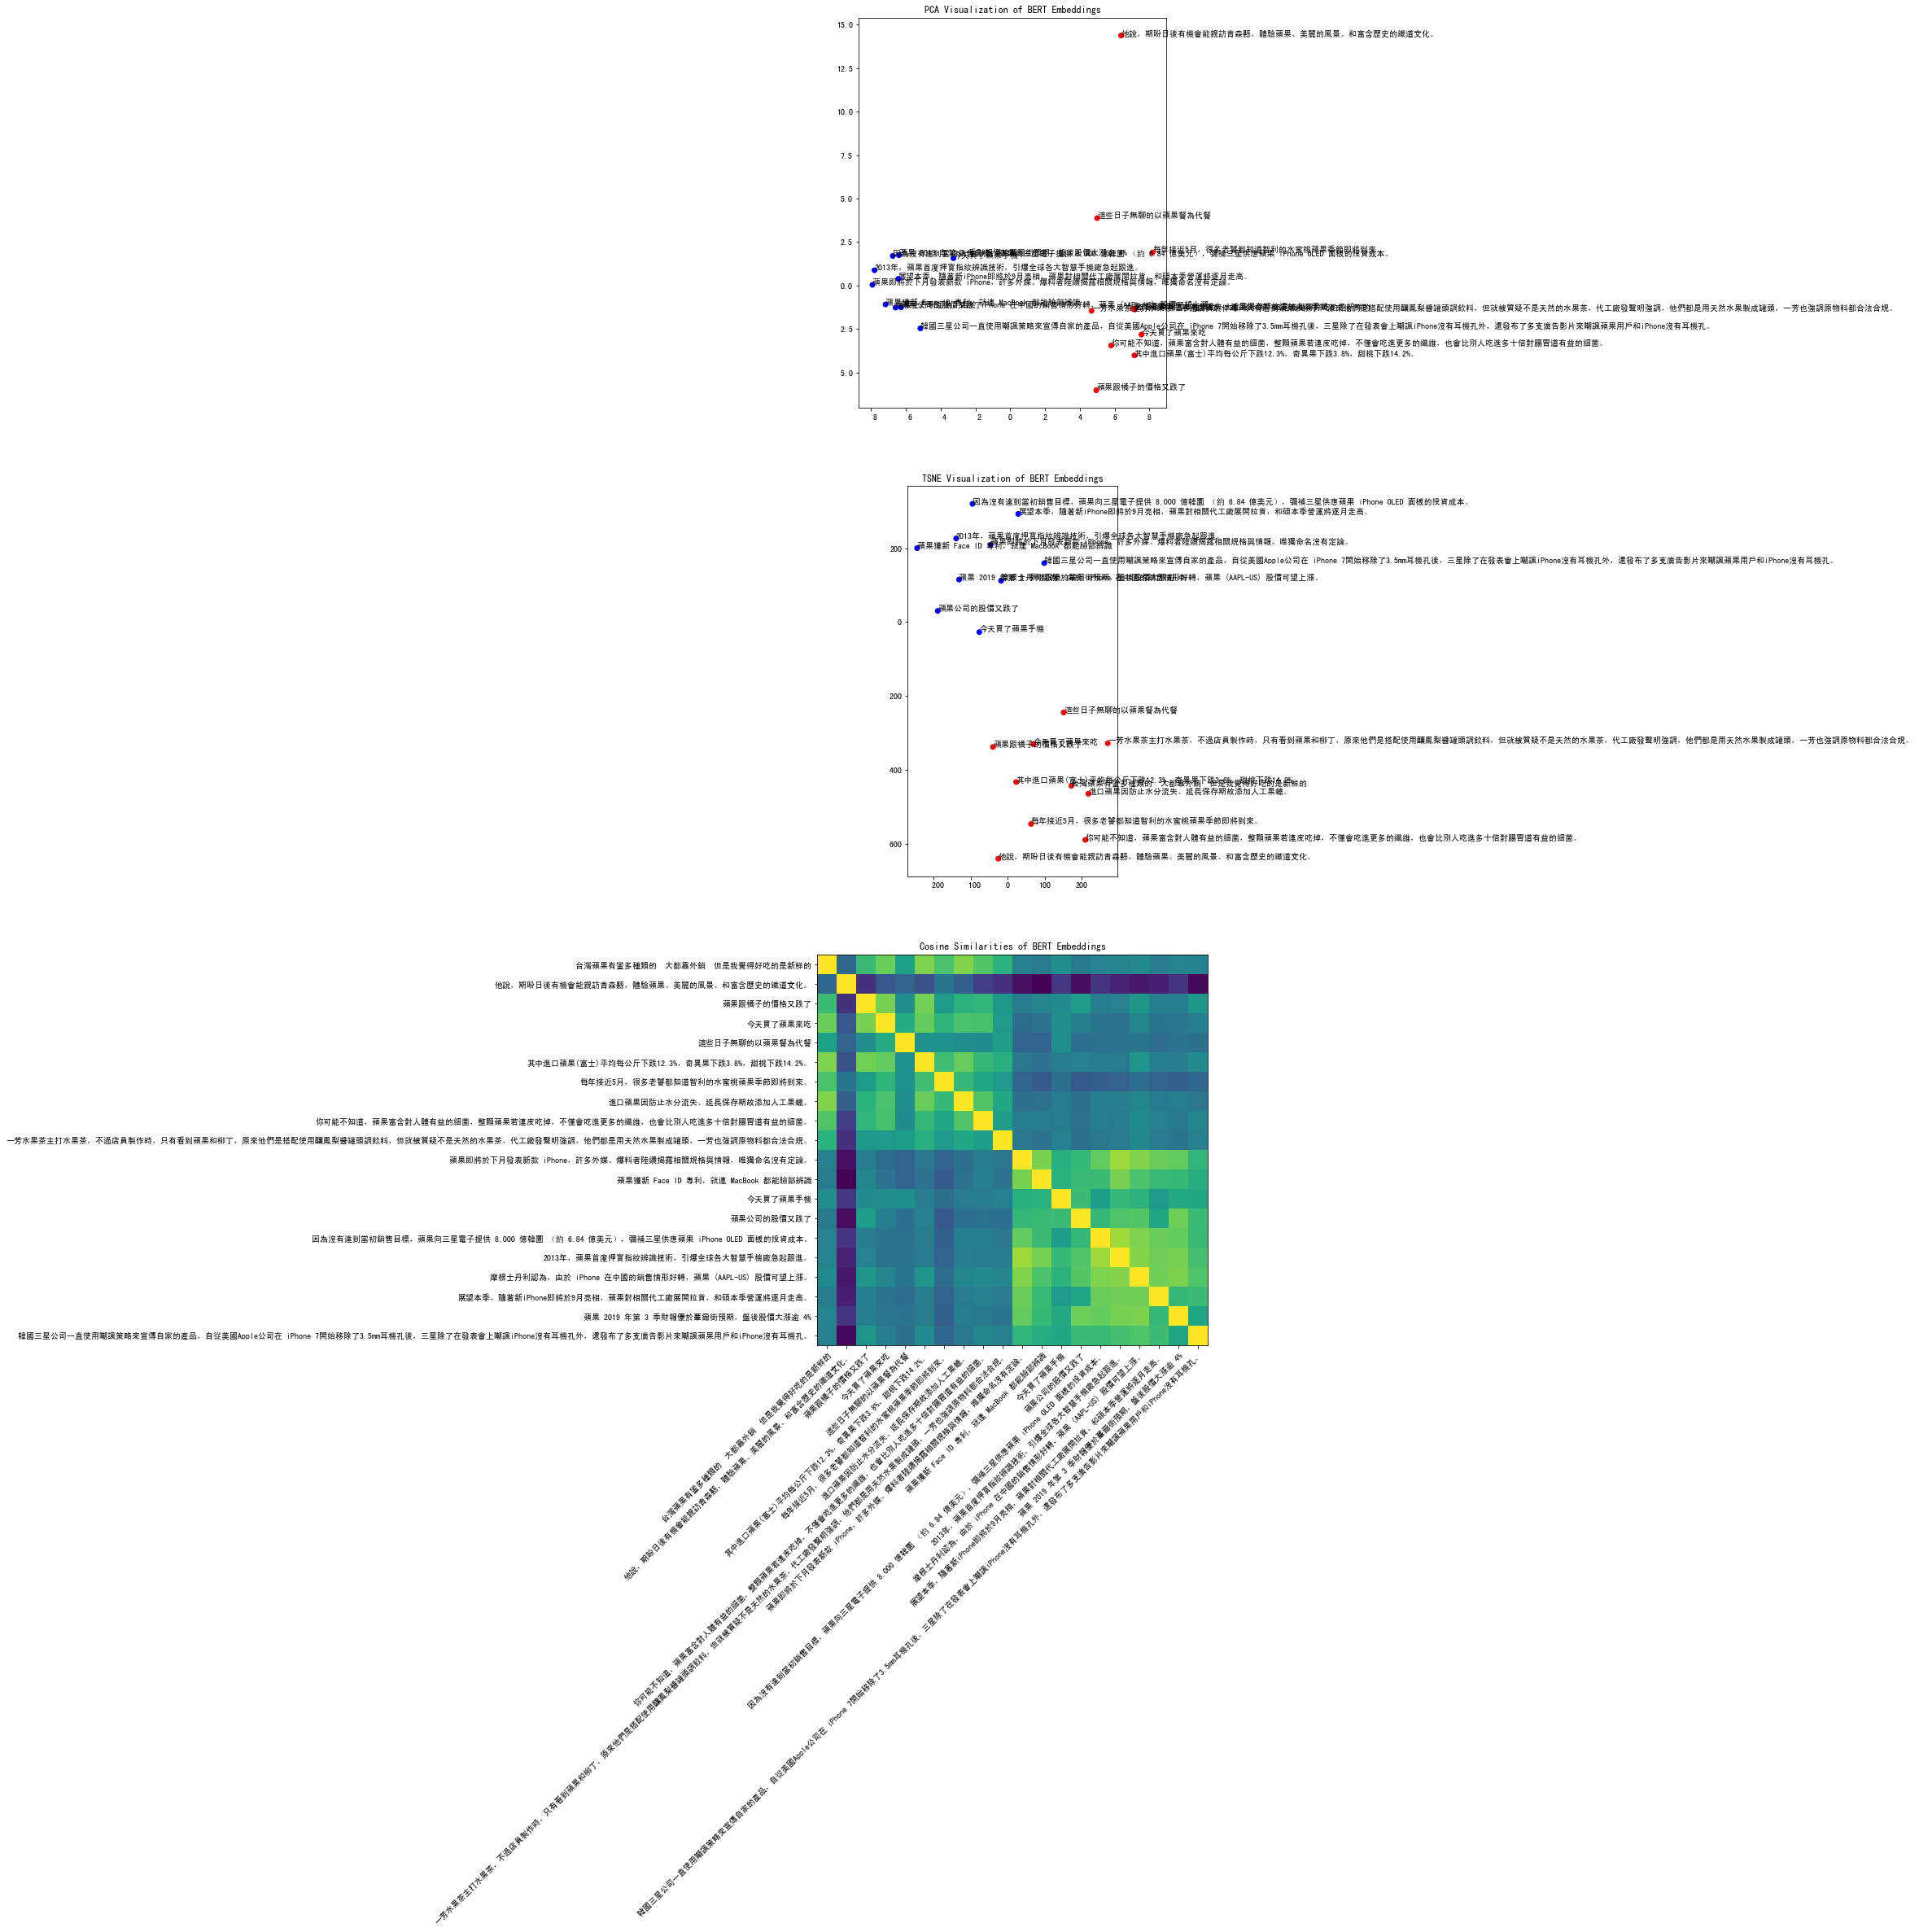

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F


def preprocess(sent, masked_indices=None): # 將句子編碼成編號向量，順便用[MASK]遮住我們想考BERT的字
    text = "[CLS]" + sent + "[SEP]"
    tokenized_text = tokenizer.tokenize(text)
    masked_tokens = []
    if masked_indices is not None:
        for masked_index in masked_indices:
            print("tokenized_text before masking: {}".format(tokenized_text))
            masked_tokens.append(tokenized_text[masked_index])
            tokenized_text[masked_index] = '[MASK]'
            print("tokenized_text after masking: {}".format(tokenized_text))

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [0] * len(tokenized_text)
    segments_tensors = torch.tensor([segments_ids])
    if masked_indices is not None:
      return masked_tokens, tokens_tensor, segments_tensors
    else:
      return tokens_tensor, segments_tensors

# 下載中文字型
!wget https://github.com/victorgau/PyConTW2018Talk/raw/master/modules/simhei.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='simhei')

# 蘋果作爲一個水果
apple_1_sents = ["台灣蘋果有蠻多種類的  大都靠外銷  但是我覺得好吃的是新鮮的",
                 "他說，期盼日後有機會能親訪青森縣，體驗蘋果、美麗的風景、和富含歷史的鐵道文化。",
                 "蘋果跟橘子的價格又跌了",
                 "今天買了蘋果來吃",
                 "這些日子無聊的以蘋果餐為代餐",
                 "其中進口蘋果(富士)平均每公斤下跌12.3%，奇異果下跌3.8%，甜桃下跌14.2%。",
                 "每年接近5月，很多老饕都知道智利的水蜜桃蘋果季節即將到來。",
                 "進口蘋果因防止水分流失、延長保存期故添加人工果蠟。",
                 "你可能不知道，蘋果富含對人體有益的細菌，整顆蘋果若連皮吃掉，不僅會吃進更多的纖維，也會比別人吃進多十倍對腸胃道有益的細菌。",
                 "一芳水果茶主打水果茶，不過店員製作時，只有看到蘋果和柳丁，原來他們是搭配使用釀鳳梨醬罐頭調飲料，但就被質疑不是天然的水果茶，"
                  "代工廠發聲明強調，他們都是用天然水果製成罐頭，一芳也強調原物料都合法合規。"]

# 蘋果作爲一家公司
apple_2_sents = ["蘋果即將於下月發表新款 iPhone，許多外媒、爆料者陸續揭露相關規格與情報，唯獨命名沒有定論。",
                 "蘋果獲新 Face ID 專利，就連 MacBook 都能臉部辨識",
                 "今天買了蘋果手機",
                 "蘋果公司的股價又跌了",
                 "因為沒有達到當初銷售目標，蘋果向三星電子提供 8,000 億韓圜 （約 6.84 億美元），彌補三星供應蘋果 iPhone OLED 面板的投資成本。",
                 "2013年，蘋果首度押寶指紋辨識技術，引爆全球各大智慧手機廠急起跟進。",
                 "摩根士丹利認為，由於 iPhone 在中國的銷售情形好轉，蘋果 (AAPL-US) 股價可望上漲。",
                 "展望本季，隨著新iPhone即將於9月亮相，蘋果對相關代工廠展開拉貨，和碩本季營運將逐月走高。",
                 "蘋果 2019 年第 3 季財報優於華爾街預期，盤後股價大漲逾 4%",
                 "韓國三星公司一直使用嘲諷策略來宣傳自家的產品，自從美國Apple公司在 iPhone 7開始移除了3.5mm耳機孔後，"
                 "三星除了在發表會上嘲諷iPhone沒有耳機孔外，還發布了多支廣告影片來嘲諷蘋果用戶和iPhone沒有耳機孔。"]

apple_sents = apple_1_sents + apple_2_sents # 將兩種語意的句子list合併成一個大的list
with torch.no_grad(): # 請模型不要計算訓練時會用到的梯度(gradient)，減少記憶體用量及加快計算速度
    embeddings = [] #初始化BERT字向量的list
    keyword_index = tokenizer.convert_tokens_to_ids(["果"])[0] #拿取「果」這個字在BERT內部的編號
    for sent in apple_sents: # 對所有在上面的list裡面的句子都計算BERT的考慮上下文的字向量
        tokens_tensor, segments_tensors = preprocess(sent) # 把中文字轉換成BERT看得懂的編號向量
        encoded_layers, _ = model(tokens_tensor, segments_tensors) # 計算BERT字向量
        keyword_position = torch.nonzero(tokens_tensor[0] == keyword_index)[0][0] # 拿取句子裡第一次出現的「果」字在句子中的位置
        embeddings.append(encoded_layers[0, keyword_position]) # 拿取句子裡第一個「果」字的向量，並加入BERT字向量的list中

# 把有N個shape為(L,C)的PyTorch Tensor的List [tensor(L,C), tensor(L,C), ..., tensor(L,C)]變成單一個shape為(N, L, C)的 PyTorch Tensor(N, L, C)
embeddings = torch.stack(embeddings, dim=0) 

# 我們要畫三張圖，因此初始化一個三行一列的畫布
fig, axes = plt.subplots(3, 1, figsize=(30, 30))

# 每個BERT字向量都有768維，我們用TSNE演算法將他們降維到2維空間以便進行視覺化
tsne_embeddings = TSNE(n_components=2, perplexity=10.0).fit_transform(embeddings.numpy())

# 每個BERT字向量都有768維，我們用PCA演算法將他們降維到2維空間以便進行視覺化
pca=PCA(n_components=3) 
pca.fit(embeddings) 
pca_embeddings = pca.transform(embeddings)

# 為蘋果的不同意思上色
colors = ['r'] * len(apple_1_sents) + ['b'] * len(apple_2_sents)

#將PCA降維的結果畫在第一行的畫布上
axes[0].scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=colors)

#把標題寫上去
axes[0].set_title("PCA Visualization of BERT Embeddings")
for i, txt in enumerate(apple_sents):
    #在每個點旁邊寫上「果」的字向量的所屬句子（上下文）
    axes[0].annotate(txt, (pca_embeddings[i,0], pca_embeddings[i,1]))

#將TSNE降維的結果畫在第二行的畫布上
axes[1].scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=colors)

#把標題寫上去
axes[1].set_title("TSNE Visualization of BERT Embeddings")
for i, txt in enumerate(apple_sents):
    #在每個點旁邊寫上「果」的字向量的所屬句子（上下文）
    axes[1].annotate(txt, (tsne_embeddings[i,0], tsne_embeddings[i,1]))

#第三張圖：首先計算每個「果」的字向量之間的餘弦相似度(cosine similarity)
products = torch.matmul(embeddings, torch.transpose(embeddings, 1, 0))
norms = torch.sqrt(torch.sum(embeddings ** 2, dim=-1))
similarities = products / (norms.unsqueeze(0) * norms.unsqueeze(1))

#matplotlib套件不喜歡PyTorch Tensor，喜歡numpy array，所以我們讓他高興一點
similarities = similarities.numpy()

#將相似度畫在第三張圖上
im = axes[2].imshow(similarities)
axes[2].set_xticks(np.arange(len(apple_sents)))
axes[2].set_yticks(np.arange(len(apple_sents)))

#為每個行列標上所屬句子
axes[2].set_xticklabels(apple_sents)
axes[2].set_yticklabels(apple_sents)

#一些讓圖比較漂亮的設定
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box')
axes[2].set_aspect('equal', 'box')
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
axes[2].set_title("Cosine Similarities of BERT Embeddings")
plt.show()


        

### Resources

 - Paper: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
 - Initial repository (with detailed examples and documentation): [pytorch-pretrained-BERT](https://github.com/huggingface/pytorch-pretrained-BERT)